# SSVEP Preprocessing (solution)

In the following notebook, you will implement some steps to clean up the recorded EEG data in order to extract interpretable frequency content for the different SSVEP classes. When in doubt, refer to the MNE documentation at https://mne.tools/stable/python_reference.html, or don't hesitate to ask a question or help each other out.

## Download the SSVEP Exoskeleton dataset

First, we again load the `SSVEPExo` dataset and extract the raw, unprocessed data into variable `raw`of datatype `mne.io.Raw`.

In [1]:
from moabb.datasets import SSVEPExo

dataset = SSVEPExo()
dataset.download()
dataset.get_data()
subj,session,run = 3, 'session_0', 'run_0'
raw = dataset.get_data(subjects=[subj])[subj][session][run]
sphere=(0,-25,0,100)
raw

<Raw | subject03_run1_raw.fif, 9 x 63040 (246.2 s), ~4.3 MB, data loaded>

Without any preprocessing, we can already see distinct peaks at the frequencies of interest for this SSVEP paradigm (13Hz, 17Hz and 21Hz) in the power spectral density. However, this will not always be the case, and these peaks are overshadowed by the power of low frequencies and other peaks the alpha activity or the powerline noise.

## Rereference

Usually, the first step in EEG preprocessing is rereferencing. EEG data is recorded as differences in electrical potential between each electrode and a fixed reference electrode, which is not present in the recorded data. Afterwards, this reference can be changed in data processing to highlight some differences in the data and remove noise that is present in all electrodes.

**Output**: the `raw : mne.io.Raw` variable rereferenced using an apt method.

**Hint:** https://mne.tools/stable/generated/mne.io.Raw.html?highlight=set_eeg_reference#mne.io.Raw.set_eeg_reference

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)


/tmp/ipykernel_33869/2970955227.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


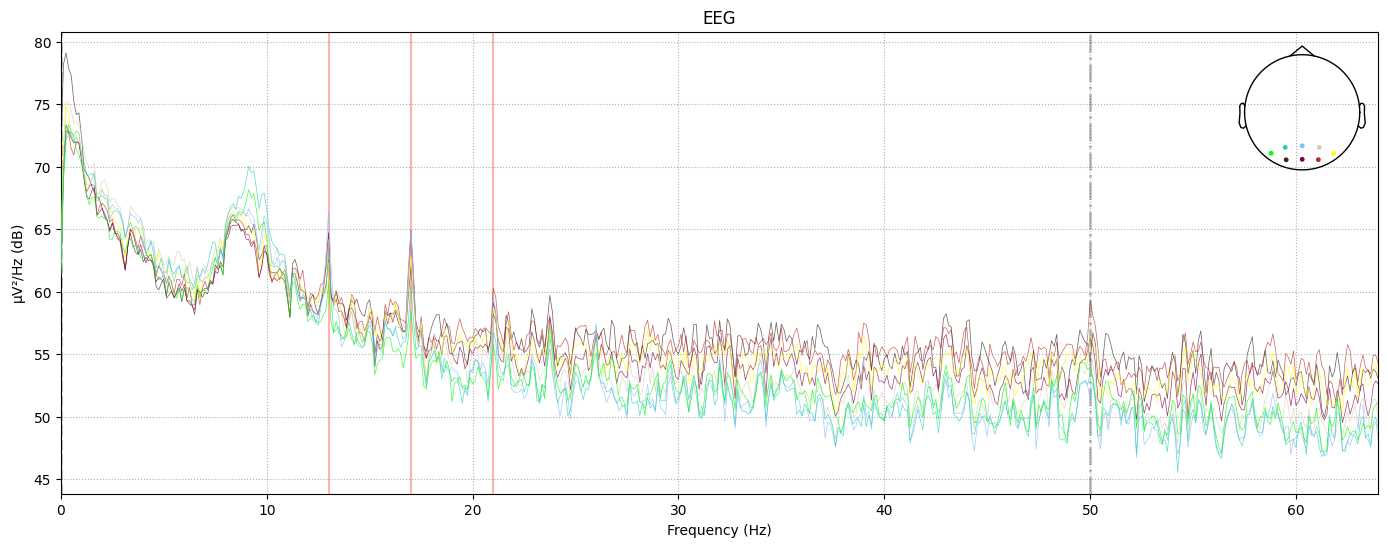

In [2]:
import matplotlib.pyplot as plt

target_frequencies = [0,13,21,17]
fig, ax = plt.subplots(1,1,figsize=(17,6))
fig = raw.plot_psd(sphere=sphere,fmax=64,ax=ax, show=False)
for f in target_frequencies:
    ax.axvline(f, color='red', alpha=0.3)
fig.show()

In [3]:
# Since no far-away electrodes that contain other brain activity
# but not the activity of interest are present, rereferencing can be ommitted here.
#_ = raw.set_eeg_reference('average')

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)


/tmp/ipykernel_33869/1553845500.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


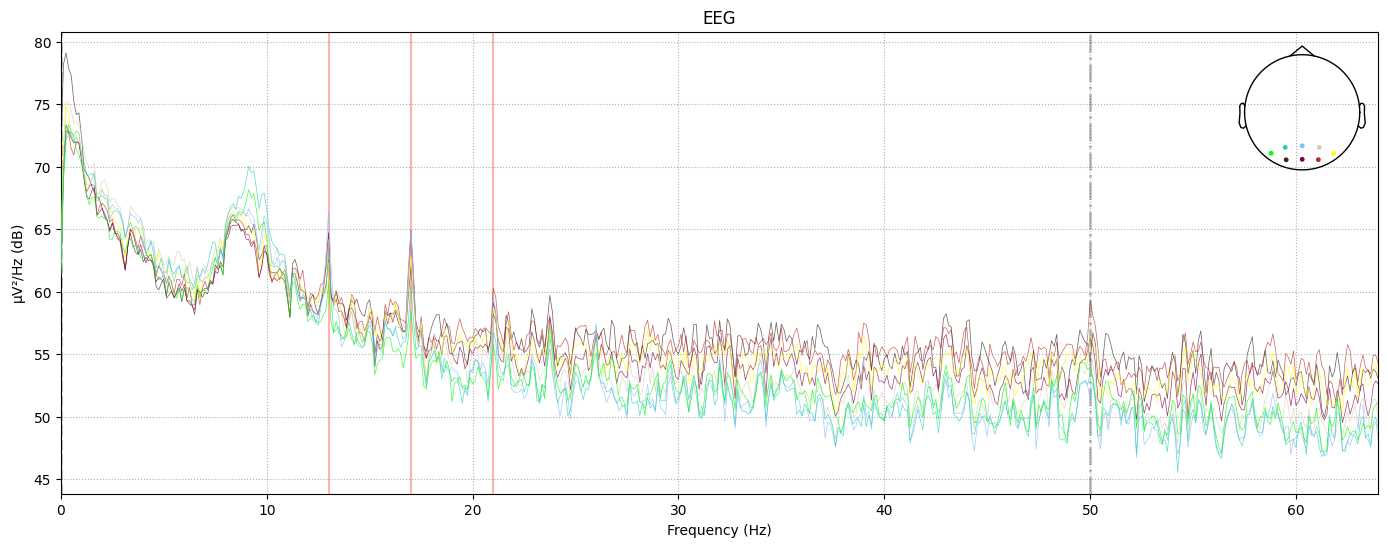

In [4]:
fig, ax = plt.subplots(1,1,figsize=(17,6))
fig = raw.plot_psd(sphere=sphere,fmax=64,ax=ax, show=False)
for f in target_frequencies:
    ax.axvline(f, color='red', alpha=0.3)
fig.show()

## Filter

Next let's remove the powerline noise.

**Output**: the `raw : mne.io.Raw` variable filtered to drop the European powerline frequency and its harmonics.

**Hint**: https://mne.tools/stable/generated/mne.io.BaseRaw.html#mne.io.BaseRaw.notch_filternotch_filter#mne.io.BaseRaw.notch_filter

In [5]:
powerline_freq = 50
# The data sample rate is 256Hz, hence the highest possible (Nyquist) 
# frequency is 256Hz/2=128Hz. 
# The maximum powerline harmonic we can use is thus 50Hz*2=100Hz < 128Hz
_ = raw.notch_filter([powerline_freq,powerline_freq*2])

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)


/tmp/ipykernel_33869/1553845500.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


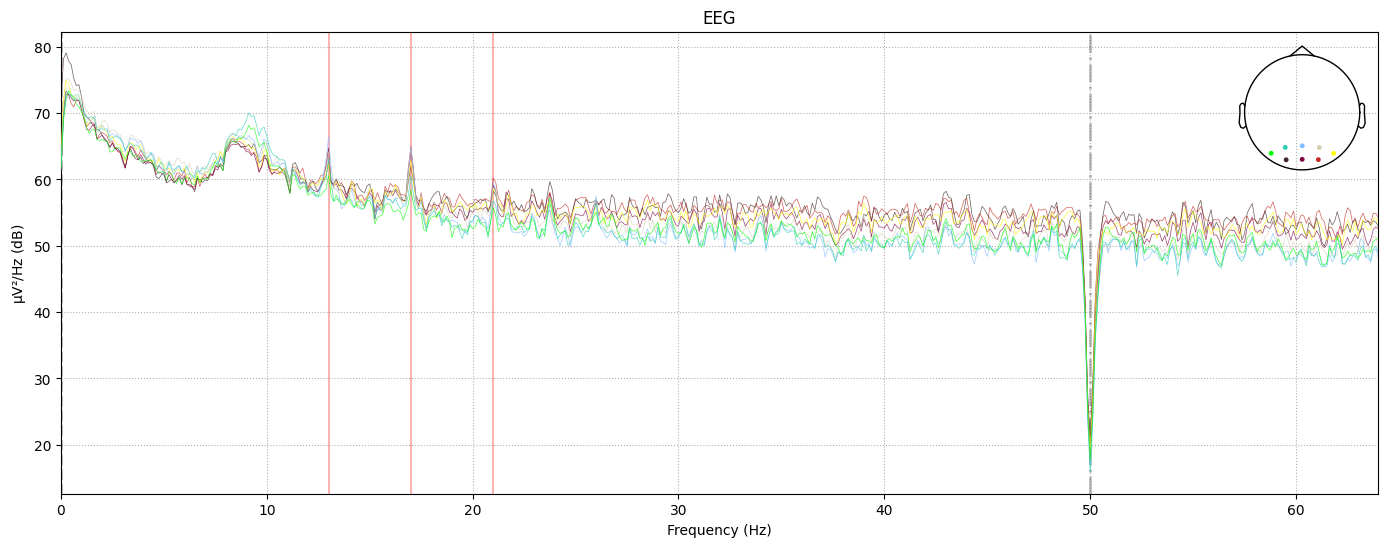

In [6]:
fig, ax = plt.subplots(1,1,figsize=(17,6))
fig = raw.plot_psd(sphere=sphere,fmax=64,ax=ax, show=False)
for f in target_frequencies:
    ax.axvline(f, color='red', alpha=0.3)
fig.show()

## Cut epochs

The EEG is recorded as a continuous, multi-channel time series and is represented as such by the `mne.io.Raw` datatype. We are, however, only interested in the EEG activity during SSVEP stimulation, which might only occur sporadically troughout the recording. In order to drop irrelevant timepoints and end up with labeled segments of EEG data suited for analysis and classification, cut the continous signal into time segments (epochs) based on the events present in the stimulation channel.

In [7]:
event_id = {
    'rest': 1,
    'stimulation/13Hz': 2,
    'stimulation/21Hz': 3,
    'stimulation/17Hz': 4,
}

Cut the continuous EEG signal in epochs each lasting for the entire duration of one SSVEP stimulation and including some pre-stimulation activity for baseline correction (see later).

**Output**: a variable `epochs : mne.Epochs` containing one epochs per event. 

**Hint**: https://mne.tools/stable/generated/mne.Epochs.html

In [8]:
from mne import find_events, Epochs

events = find_events(raw)
epochs = Epochs(raw, events=events, event_id=event_id, tmin=-3, tmax=5, baseline=(None,0), preload=True)

32 events found
Event IDs: [1 2 3 4]
Not setting metadata
32 matching events found
Setting baseline interval to [-3.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 32 events and 2049 original time points ...
0 bad epochs dropped


The psd should look a lot cleaner now and can be split up per stimulation class. Some harmonics should also be visible now, check if you can spot them.

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


/tmp/ipykernel_33869/3817679817.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


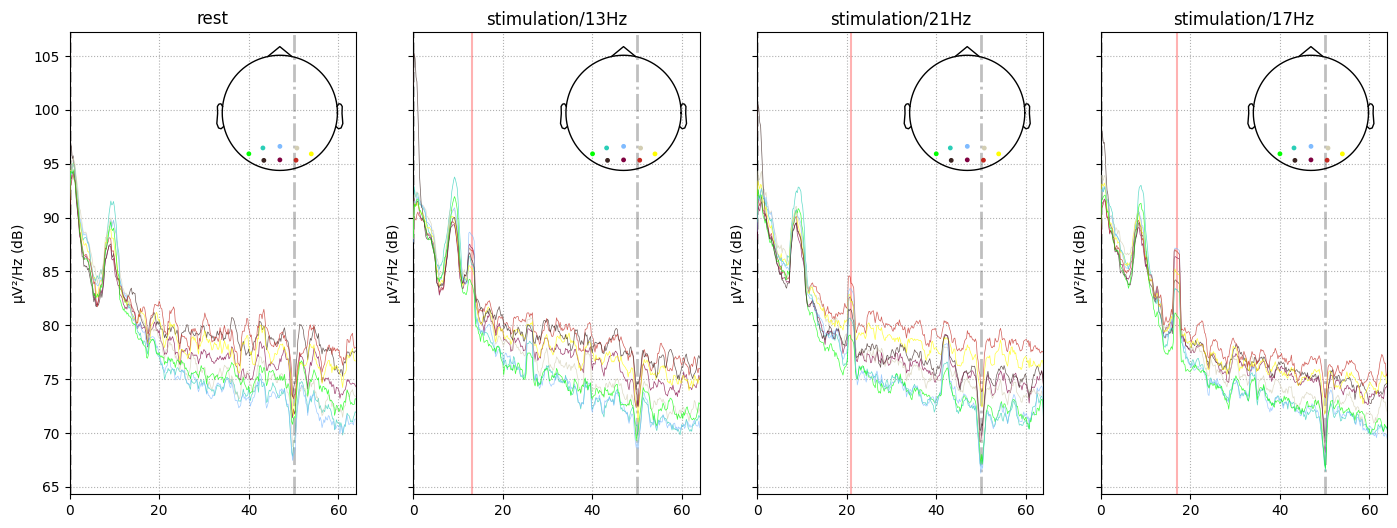

In [9]:
fig, axs = plt.subplots(1,4, figsize=(17,6), sharex=True, sharey=True)
for i,label in enumerate(event_id.keys()):
    axs[i].axvline(target_frequencies[i], color='red', alpha=0.3)
    epochs[label].plot_psd(
        sphere=sphere, tmin=0, fmax=64, show=False, ax=axs[i],
    )
    axs[i].set_title(label)
fig.show()

This looks nice, but the result is not really fit for analysis. For instance, the alpha activity and the lowest frequencies are still a lot more powerful than the frequencies of interest.

## Frequency band power feature extraction

### Time-frequency transform

To inspect which frequencies are prevalent in which classes and to allow for feature extraction, we can now plot frequency powers for the stimulation frequencies and their harmonics. We do this by applying a set of multitaper filters for the frequencies of interest to the data. If you want to gain a better understanding of EEG analysis in the time-frequency domain, please refer to Mike X Cohen's Analyzing Neural Time Series Data videos: https://www.youtube.com/channel/UCUR_LsXk7IYyueSnXcNextQ/playlists?view=50&sort=dd&shelf_id=1

In [10]:
import numpy as np
from mne.time_frequency import tfr_multitaper, tfr_morlet

base_freqs = np.array([13]*9 + [17]*7 + [21]*6)
harmonics = np.array([1,2,3,4,5,6,7,8,9,1,2,3,4,5,6,7,1,2,3,4,5,6])
freqs = base_freqs*harmonics
n_cycles = freqs*3
epochs_tfr = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, average=False, return_itc=False)
epochs_tfr

Not setting metadata


<EpochsTFR | time : [-3.000000, 5.000000], freq : [13.000000, 126.000000], epochs : 32, channels : 8, ~88.1 MB>

/data/.virtualenvs/ssvep-workshop/lib/python3.9/site-packages/seaborn/categorical.py:3025: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)


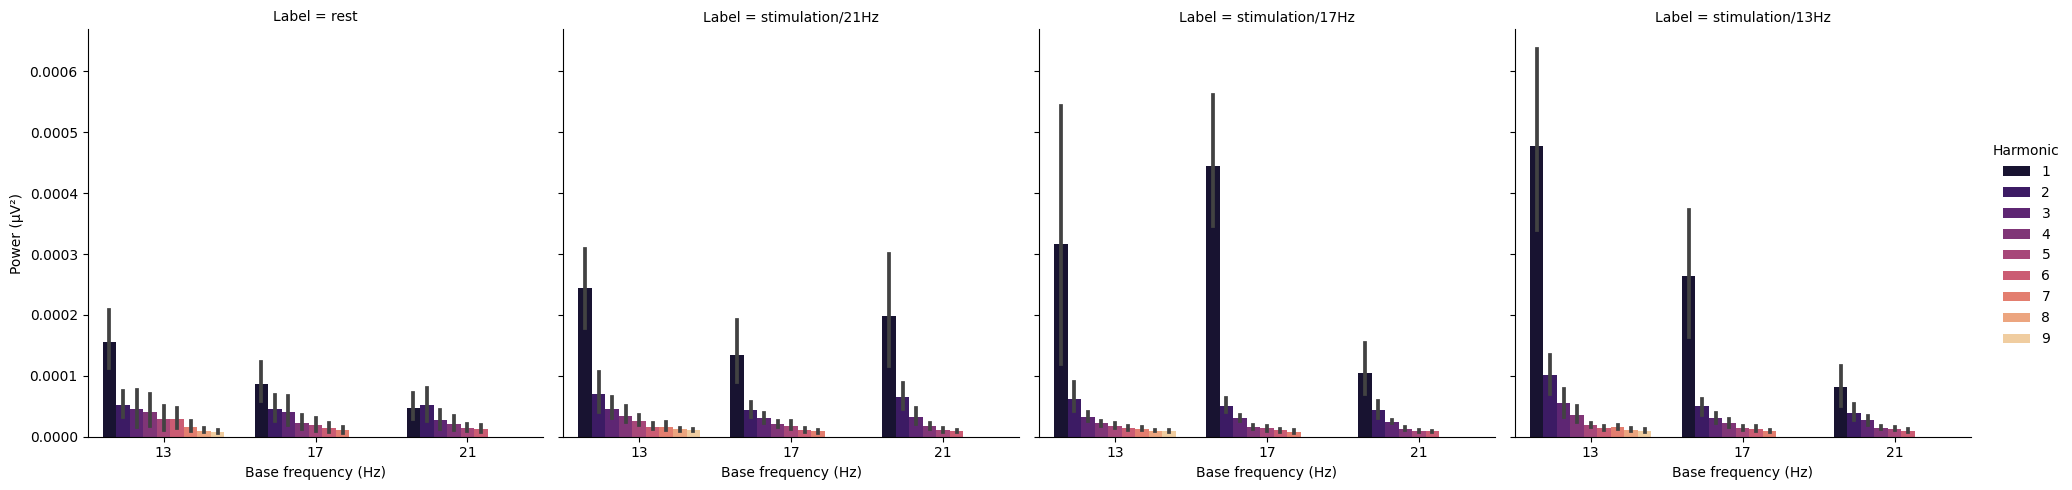

In [11]:
import seaborn as sns
import pandas as pd
from mne.epochs import make_metadata

mean_chan_power = epochs_tfr.data.mean(axis=(1,3))
sfreq = epochs.info['sfreq']
meta,_,_ = make_metadata(events, event_id, epochs.tmin, epochs.tmax, sfreq)
labels = meta['event_name']
df = pd.DataFrame(mean_chan_power.T, columns=labels)
df['Base frequency (Hz)'] = base_freqs
df['Harmonic'] = harmonics
df = df.melt(id_vars=['Base frequency (Hz)', 'Harmonic'], var_name='Label', value_name='Power (µV²)')
sns.catplot(kind='bar', col='Label', data=df, x='Base frequency (Hz)', hue='Harmonic', y='Power (µV²)', ax=axs[i], palette='magma')

### Baseline correction

Unfortunately, these features are not that easy to interpret and unfit to use for classification.
Ideally, the stimulation frequency of a class would be present as the frequency with the highest power.
There are several problems preventing this:
* The 1/f scaling characteristic makes it hard to visualize data across a wide frequency range. In the example above, the harmonics, while containing relevant information, fade away as they have increasingly higher frequencies.
* The 1/f scaling characteristic also prevents quantitative comparisons across frequencies. In the example above, the 1st harmonic of 13Hz has higher power than the first harmonic of 21Hz while 21Hz is being stimulated.
* Background noise at specific frequencies contaminates specific epochs and/or channels.
* Task-related changes in power in specific epochs and/or channels can be obscured by background activity or noise of higher power that is present regardless of the stimulation (e.g. alpha activity).
* It is hard to discern the trials where no targets were selected from the others.

To reveal the increase in frequency power generated by SSVEP stimulation, instead of using the raw power at specific frequencies as features, in each epoch, channel and frequency we want to look at increases or decreases of power relative to some baseline period in which no stimulation is happening. This will correct for the 1/f characteristic, and continuous noise present in some epochs or channels.

Choose a relevant baselining window and method and apply baselining to the timfe-frequency epochs. Does this work well for all subjects?

**Output**: the baseline corrected `epochs_tfr: mne.time_frequency.EpochsTFR` variable

**Hint**: https://mne.tools/stable/generated/mne.time_frequency.EpochsTFR.html#mne.time_frequency.EpochsTFR.apply_baseline

In [12]:
epochs_tfr.apply_baseline((-2.5, -.5), mode='ratio')

Applying baseline correction (mode: ratio)


<EpochsTFR | time : [-3.000000, 5.000000], freq : [13.000000, 126.000000], epochs : 32, channels : 8, ~88.1 MB>

Finally, after baseline correction, discard the baseline period so the resulting epochs contain only stimulated data.

**Output**: the cropped `epochs_tfr: mne.time_frequency.EpochsTFR` variable starting at 0s.

**Hint**: https://mne.tools/stable/generated/mne.time_frequency.EpochsTFR.html#mne.time_frequency.EpochsTFR.crop

In [13]:
epochs.crop(tmin=0, tmax=5)

Number of events,32
Events,rest: 8stimulation/13Hz: 8stimulation/17Hz: 8stimulation/21Hz: 8
Time range,0.000 – 5.000 s
Baseline,-3.000 – 0.000 s


/data/.virtualenvs/ssvep-workshop/lib/python3.9/site-packages/seaborn/categorical.py:3025: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)


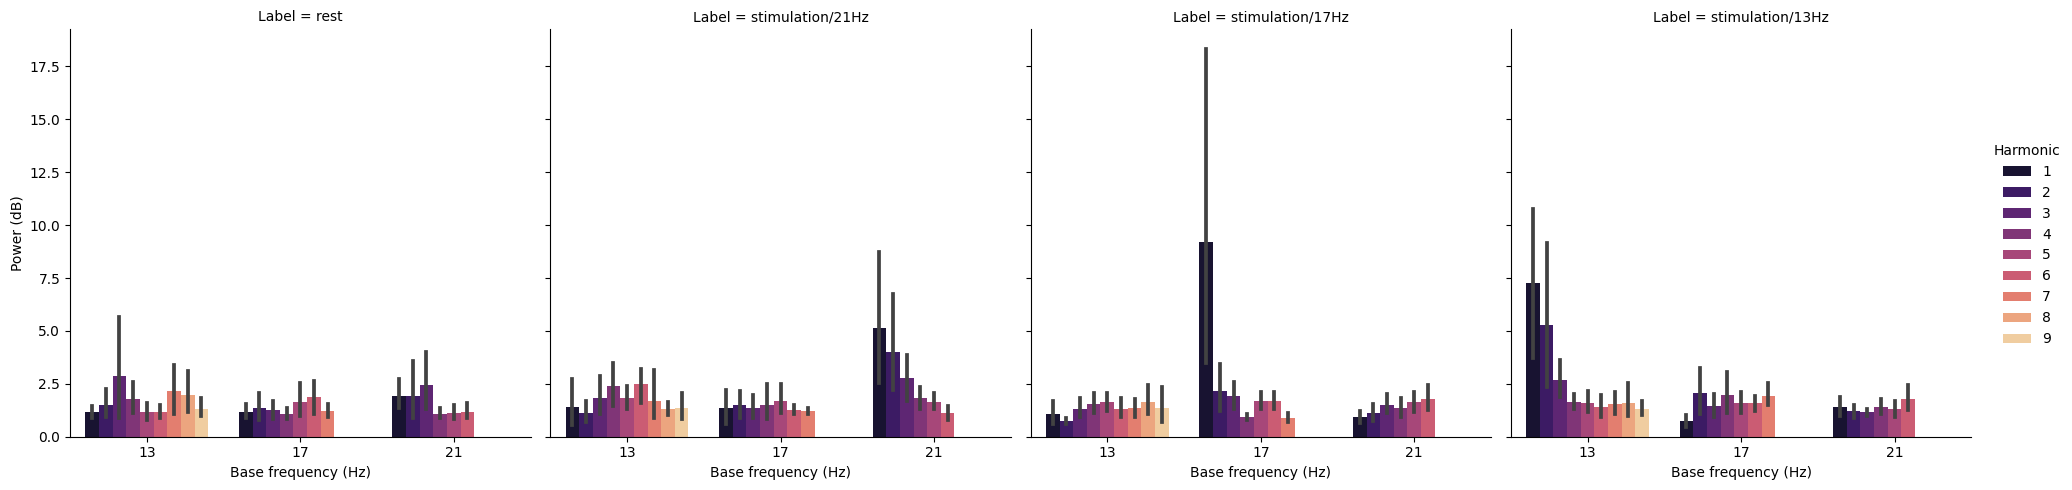

In [14]:
mean_chan_power = epochs_tfr.data.mean(axis=(1,3))
mean_chan_power_db = 10*np.log10(mean_chan_power)

df = pd.DataFrame(mean_chan_power.T, columns=labels)
df['Base frequency (Hz)'] = base_freqs
df['Harmonic'] = harmonics
df = df.melt(id_vars=['Base frequency (Hz)', 'Harmonic'], var_name='Label', value_name='Power (dB)')
sns.catplot(kind='bar', col='Label', data=df, x='Base frequency (Hz)', hue='Harmonic', y='Power (dB)', ax=axs[i], palette='magma')